In [51]:
import pandas as pd
import json
import os
from PIL import Image
from tqdm.notebook import tqdm
from transformers import Qwen2VLForConditionalGeneration, PaliGemmaForConditionalGeneration, MllamaForConditionalGeneration, AutoModelForCausalLM, LlavaNextProcessor, LlavaNextForConditionalGeneration, AutoProcessor, AutoTokenizer, AutoModel
from pathlib import Path
import torch
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import gc
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker


In [3]:
with open("./my2DlinePlots/metadata.json", 'r') as f:
    metadata = json.load(f)

df = pd.DataFrame.from_dict(metadata, orient='index')

df = df.reset_index().rename(columns={'index': 'filename'})

df['image_path'] = df['filename'].apply(lambda x: os.path.join("./my2DlinePlots", x + ".png"))

df = df.drop(columns=['grid_size'])

# Add prompt column
prompts = {
    "prompt1": "How many times do the blue and red lines touch each other? Answer with a number in curly brackets, e.g., {5}.",
    "prompt2": "Count the intersection points where the blue and red lines meet. Put your answer in curly brackets, e.g., {2}."
}

# Duplicate rows for each prompt
data = pd.concat([df, df], ignore_index=True)
data['prompt'] = [prompts["prompt1"] if i % 2 == 0 else prompts["prompt2"] for i in range(len(data))]


model_names = [
    "Qwen/Qwen2-VL-7B-Instruct",
    #"google/paligemma-3b-pt-448",
    "meta-llama/Llama-3.2-11B-Vision-Instruct",
    "llava-hf/llava-v1.6-mistral-7b-hf",
    "OpenGVLab/InternVL2_5-8B-MPO",
    "microsoft/Phi-3.5-vision-instruct",
]

for model_name in model_names:
    data[model_name] = -1

data

,filename,gt,linewidth,resolution,distances,image_path,prompt,Qwen/Qwen2-VL-7B-Instruct,meta-llama/Llama-3.2-11B-Vision-Instruct,llava-hf/llava-v1.6-mistral-7b-hf,OpenGVLab/InternVL2_5-8B-MPO,microsoft/Phi-3.5-vision-instruct
0,gt_1_image_0_thickness_2_resolution_384,1,2,100,"[1.0, 10.0, 0.0]",./my2DlinePlots/gt_1_image_0_thickness_2_resol...,How many times do the blue and red lines touch...,-1,-1,-1,-1,-1
1,gt_1_image_0_thickness_4_resolution_384,1,4,100,"[1.0, 10.0, 0.0]",./my2DlinePlots/gt_1_image_0_thickness_4_resol...,Count the intersection points where the blue a...,-1,-1,-1,-1,-1
2,gt_1_image_0_thickness_2_resolution_768,1,2,200,"[1.0, 10.0, 0.0]",./my2DlinePlots/gt_1_image_0_thickness_2_resol...,How many times do the blue and red lines touch...,-1,-1,-1,-1,-1
3,gt_1_image_0_thickness_4_resolution_768,1,4,200,"[1.0, 10.0, 0.0]",./my2DlinePlots/gt_1_image_0_thickness_4_resol...,Count the intersection points where the blue a...,-1,-1,-1,-1,-1
4,gt_1_image_0_thickness_2_resolution_1152,1,2,300,"[1.0, 10.0, 0.0]",./my2DlinePlots/gt_1_image_0_thickness_2_resol...,How many times do the blue and red lines touch...,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
3595,gt_2_image_299_thickness_4_resolution_384,2,4,100,"[4.0, 6.0, 1.0]",./my2DlinePlots/gt_2_image_299_thickness_4_res...,Count the intersection points where the blue a...,-1,-1,-1,-1,-1
3596,gt_2_image_299_thickness_2_resolution_768,2,2,200,"[4.0, 6.0, 1.0]",./my2DlinePlots/gt_2_image_299_thickness_2_res...,How many times do the blue and red lines touch...,-1,-1,-1,-1,-1
3597,gt_2_image_299_thickness_4_resolution_768,2,4,200,"[4.0, 6.0, 1.0]",./my2DlinePlots/gt_2_image_299_thickness_4_res...,Count the intersection points where the blue a...,-1,-1,-1,-1,-1
3598,gt_2_image_299_thickness_2_resolution_1152,2,2,300,"[4.0, 6.0, 1.0]",./my2DlinePlots/gt_2_image_299_thickness_2_res...,How many times do the blue and red lines touch...,-1,-1,-1,-1,-1


In [55]:
def get_model_prediction(model, processor, image, prompt):
    if model_name == "Qwen/Qwen2-VL-7B-Instruct":
        conversation = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                    },
                    {"type": "text", "text": prompt},
                ],
            }
        ]

        # Preprocess the inputs
        text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
        # Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

        inputs = processor(
            text=[text_prompt], images=[image], padding=True, return_tensors="pt"
        )
        inputs = inputs.to("cuda")

        # Inference: Generation of the output
        output_ids = model.generate(**inputs, max_new_tokens=16)
        generated_ids = [
            output_ids[len(input_ids) :]
            for input_ids, output_ids in zip(inputs.input_ids, output_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        # check if output text is list
        if isinstance(output_text, list):
            if output_text[0].strip("[]{}") == "":
                return -1
            else:
                return int(output_text[0].strip("[]{}"))
        else:
            if output_text.strip("[]{}") == "":
                return -1
            else:
                return int(output_text.strip("[]{}"))
    
    elif model_name == "google/paligemma-3b-pt-448":
        # Process inputs and move to MPS
        model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(torch.bfloat16).to(model.device)
        
        input_len = model_inputs["input_ids"].shape[-1]

        # Generate output
        with torch.inference_mode():
            generation = model.generate(**model_inputs, max_new_tokens=16, do_sample=False)
            generation = generation[0][input_len:]
            decoded = processor.decode(generation, skip_special_tokens=True)
            return decoded
    
    elif model_name == "meta-llama/Llama-3.2-11B-Vision-Instruct":
        messages = [
            {"role": "user", "content": [
                {"type": "image"},
                {"type": "text", "text": prompt}
            ]}
        ]
        input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(
            image,
            input_text,
            add_special_tokens=False,
            return_tensors="pt"
        ).to(model.device)

        output = model.generate(**inputs, max_new_tokens=1024)
        raw = processor.decode(output[0])
        response = raw.split("<|start_header_id|>assistant<|end_header_id|>")[1].split("<|eot_id|>")[0].strip()

        # Try to find integers within curly braces first (e.g., "{2}")
        match = re.search(r"\{(\d+)\}", response)
        if match:
            return int(match.group(1))
        
        # Then try to find standalone integers
        match = re.search(r"\b(\d+)\b", response) #\b ensures it is a whole word
        if match:
            return int(match.group(1))

        # Handle "twice", "two", "three", "four", etc.
        response = response.lower()
        if "twice" in response or "two" in response:
            return 2
        elif "three" or "thrice" in response:
            return 3
        elif "four" in response:
            return 4
        elif "one" or "once" in response:
            return 1
        
        return response
    
    elif model_name == "llava-hf/llava-v1.6-mistral-7b-hf":
        conversation = [
            {

            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image"},
                ],
            },
        ]
        prompt_processed = processor.apply_chat_template(conversation, add_generation_prompt=True)

        inputs = processor(images=image, text=prompt_processed, return_tensors="pt").to("cuda:0")

        # autoregressively complete prompt
        output = model.generate(**inputs, max_new_tokens=16, pad_token_id=processor.tokenizer.pad_token_id)

        out = processor.decode(output[0], skip_special_tokens=True)
        out = out.split("[/INST]")[1].strip().strip("{}")
        return int(out)
    
    elif model_name == "OpenGVLab/InternVL2_5-8B-MPO":
        IMAGENET_MEAN = (0.485, 0.456, 0.406)
        IMAGENET_STD = (0.229, 0.224, 0.225)

        def build_transform(input_size):
            MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
            transform = T.Compose([
                T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
                T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
                T.ToTensor(),
                T.Normalize(mean=MEAN, std=STD)
            ])
            return transform

        def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
            best_ratio_diff = float('inf')
            best_ratio = (1, 1)
            area = width * height
            for ratio in target_ratios:
                target_aspect_ratio = ratio[0] / ratio[1]
                ratio_diff = abs(aspect_ratio - target_aspect_ratio)
                if ratio_diff < best_ratio_diff:
                    best_ratio_diff = ratio_diff
                    best_ratio = ratio
                elif ratio_diff == best_ratio_diff:
                    if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                        best_ratio = ratio
            return best_ratio

        def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
            orig_width, orig_height = image.size
            aspect_ratio = orig_width / orig_height

            # calculate the existing image aspect ratio
            target_ratios = set(
                (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
                i * j <= max_num and i * j >= min_num)
            target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

            # find the closest aspect ratio to the target
            target_aspect_ratio = find_closest_aspect_ratio(
                aspect_ratio, target_ratios, orig_width, orig_height, image_size)

            # calculate the target width and height
            target_width = image_size * target_aspect_ratio[0]
            target_height = image_size * target_aspect_ratio[1]
            blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

            # resize the image
            resized_img = image.resize((target_width, target_height))
            processed_images = []
            for i in range(blocks):
                box = (
                    (i % (target_width // image_size)) * image_size,
                    (i // (target_width // image_size)) * image_size,
                    ((i % (target_width // image_size)) + 1) * image_size,
                    ((i // (target_width // image_size)) + 1) * image_size
                )
                # split the image
                split_img = resized_img.crop(box)
                processed_images.append(split_img)
            assert len(processed_images) == blocks
            if use_thumbnail and len(processed_images) != 1:
                thumbnail_img = image.resize((image_size, image_size))
                processed_images.append(thumbnail_img)
            return processed_images

        def load_image(image, input_size=448, max_num=12):
            transform = build_transform(input_size=input_size)
            images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
            pixel_values = [transform(image) for image in images]
            pixel_values = torch.stack(pixel_values)
            return pixel_values

        # set the max number of tiles in `max_num`
        pixel_values = load_image(image, max_num=12).to(torch.float16).cuda()
        generation_config = dict(max_new_tokens=1024, do_sample=True)

        question = '<image>\n' + prompt
        response = model.chat(processor, pixel_values, question, generation_config)
        
        match = re.search(r"\d+", response)
        if match:
            return int(match.group())
        elif "one" in response:
            return 1
        elif "two" in response:
            return 2
        elif "three" in response:
            return 3
        elif "not" in response:
            return 0
        else:
            return response

    elif model_name == "microsoft/Phi-3.5-vision-instruct":    
        message = [
            {"role": "user", "content": f"<|user|>\n<|image_1|>\n{prompt}<|end|>\n<|assistant|>\n"},
        ]

        prompt = processor.tokenizer.apply_chat_template(
        message, 
        tokenize=False, 
        add_generation_prompt=True
        )

        inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0") 

        generation_args = { 
            "max_new_tokens": 16, 
            "do_sample": False, 
        } 

        generate_ids = model.generate(**inputs, 
        eos_token_id=processor.tokenizer.eos_token_id, 
        **generation_args
        )

        # remove input tokens 
        generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
        response = processor.batch_decode(generate_ids, 
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=False)[0] 

        return int(response.strip("{}"))


In [56]:
def get_huggingface_token():
    # Define the path to the token file (updated path)
    token_file = Path.home() / ".cache" / "huggingface" / "token"

    # Check if the token file exists
    if token_file.exists():
        with open(token_file, "r") as file:
            token = file.read().strip()
            return token
    else:
        raise FileNotFoundError("Hugging Face token file not found. Please run 'huggingface-cli login'.")

In [57]:
for model_name in model_names:
    print(f"Evaluating {model_name}...")
    if model_name == "Qwen/Qwen2-VL-7B-Instruct":
        model = Qwen2VLForConditionalGeneration.from_pretrained(
            model_name, torch_dtype="auto", device_map="auto"
        )
        processor = AutoProcessor.from_pretrained(model_name)
    
    elif model_name == "google/paligemma-3b-pt-448":
        model = PaliGemmaForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            token = get_huggingface_token()
        ).eval()
        processor = AutoProcessor.from_pretrained(model_name)
   
    elif model_name == "meta-llama/Llama-3.2-11B-Vision-Instruct":
        model = MllamaForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )
        processor = AutoProcessor.from_pretrained(model_name)

    elif model_name == "llava-hf/llava-v1.6-mistral-7b-hf":
        model = LlavaNextForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="auto",
            use_flash_attention_2=True,
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16) 

        processor = LlavaNextProcessor.from_pretrained(model_name)
        processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id

    elif model_name == "OpenGVLab/InternVL2_5-8B-MPO":
        processor = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

        def split_model(model_name):
            device_map = {}
            world_size = torch.cuda.device_count()
            num_layers = {
                'InternVL2_5-1B': 24, 'InternVL2_5-2B': 24, 'InternVL2_5-4B': 36, 'InternVL2_5-8B': 32,
                'InternVL2_5-26B': 48, 'InternVL2_5-38B': 64, 'InternVL2_5-78B': 80}[model_name]
            # Since the first GPU will be used for ViT, treat it as half a GPU.
            num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
            num_layers_per_gpu = [num_layers_per_gpu] * world_size
            num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
            layer_cnt = 0
            for i, num_layer in enumerate(num_layers_per_gpu):
                for j in range(num_layer):
                    device_map[f'language_model.model.layers.{layer_cnt}'] = i
                    layer_cnt += 1
            device_map['vision_model'] = 0
            device_map['mlp1'] = 0
            device_map['language_model.model.tok_embeddings'] = 0
            device_map['language_model.model.embed_tokens'] = 0
            device_map['language_model.output'] = 0
            device_map['language_model.model.norm'] = 0
            device_map['language_model.lm_head'] = 0
            device_map[f'language_model.model.layers.{num_layers - 1}'] = 0

            return device_map

        device_map = split_model('InternVL2_5-8B')
        model = AutoModel.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            load_in_8bit=True,
            low_cpu_mem_usage=True,
            use_flash_attn=True,
            trust_remote_code=True,
            device_map=device_map).eval()

    elif model_name == "microsoft/Phi-3.5-vision-instruct":
        model = AutoModelForCausalLM.from_pretrained(
            model_name, 
            device_map="cuda", 
            trust_remote_code=True, 
            torch_dtype="auto", 
            _attn_implementation='flash_attention_2'
        )

        # for best performance, use num_crops=4 for multi-frame, num_crops=16 for single-frame.
        processor = AutoProcessor.from_pretrained(model_name,
                                                  trust_remote_code=True,
                                                  num_crops=16
                                                  )
    
    # Iterate through the DataFrame rows
    for index, row in tqdm(data.iterrows(), total=len(data), desc=f"{model_name}"):
        image_path = row['image_path']
        prompt = row['prompt']

        # Load the image
        image = Image.open(image_path)
        
        # Get the model prediction for the image and prompt using model specific inference
        prediction = get_model_prediction(model, processor, image, prompt) 

        # Store the prediction in the DataFrame
        data.loc[index, model_name] = prediction

    # delete model and free memory
    del model
    del processor

    gc.collect()

    torch.cuda.empty_cache() 

    print("\n")


Evaluating Qwen/Qwen2-VL-7B-Instruct...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Qwen/Qwen2-VL-7B-Instruct:   0%|          | 0/3600 [00:00<?, ?it/s]



Evaluating meta-llama/Llama-3.2-11B-Vision-Instruct...


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

meta-llama/Llama-3.2-11B-Vision-Instruct:   0%|          | 0/3600 [00:00<?, ?it/s]



Evaluating llava-hf/llava-v1.6-mistral-7b-hf...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

llava-hf/llava-v1.6-mistral-7b-hf:   0%|          | 0/3600 [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa-NeXT should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.




Evaluating OpenGVLab/InternVL2_5-8B-MPO...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

OpenGVLab/InternVL2_5-8B-MPO:   0%|          | 0/3600 [00:00<?, ?it/s]

/tmp/ipykernel_4187817/2303040419.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[index, model_name] = prediction




Evaluating microsoft/Phi-3.5-vision-instruct...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

microsoft/Phi-3.5-vision-instruct:   0%|          | 0/3600 [00:00<?, ?it/s]

In [ ]:
# store pandas dataframe
data.to_csv("data.csv", index=False)

In [126]:
# load the dataframe from csv
data = pd.read_csv("data.csv")

In [127]:
# dealing with disrepencies in the data
data["OpenGVLab/InternVL2_5-8B-MPO"][379] = '0'
data["OpenGVLab/InternVL2_5-8B-MPO"] = data["OpenGVLab/InternVL2_5-8B-MPO"].apply(lambda x: int(x) if x != "{}" else -1)

/tmp/ipykernel_866560/2218693236.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["OpenGVLab/InternVL2_5-8B-MPO"][379] = '0'
/tmp/ipykernel_866560/2218693236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

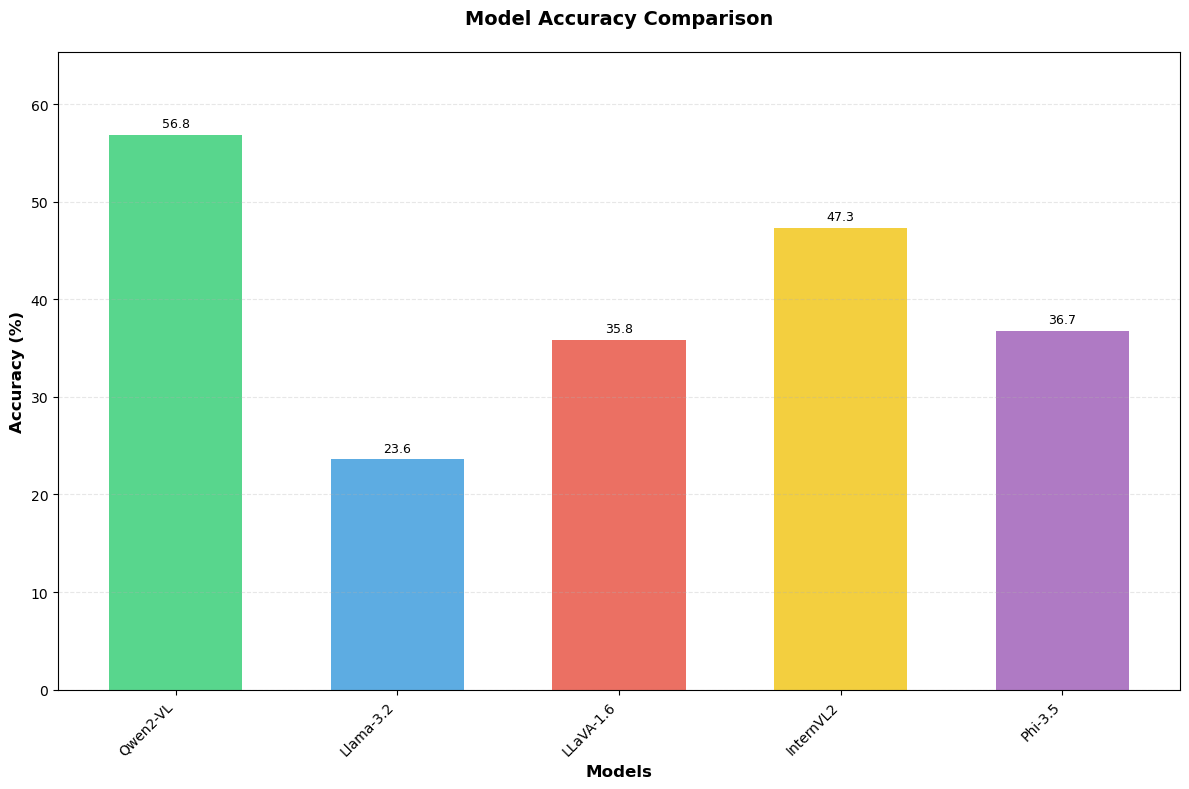

In [128]:
# Assuming we have the data and model_names from previous calculations
models = ['Qwen2-VL', 'Llama-3.2', 'LLaVA-1.6', 'InternVL2', 'Phi-3.5']

# Calculate overall accuracy
accuracy_list = []
for model_name in model_names:
    data[f'{model_name}_accuracy'] = (data[model_name] == data['gt']).astype(int)
    overall_accuracy = data[f'{model_name}_accuracy'].mean() * 100
    accuracy_list.append(overall_accuracy)

# Set figure size
plt.figure(figsize=(12, 8))

# Define colors - using a professional color palette
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6']  # Green, Blue, Red, Yellow, Purple

# Create the bar plot with different colors
bars = plt.bar(np.arange(len(models)), 
               accuracy_list, 
               width=0.6,
               color=colors,
               alpha=0.8)

# Customize the plot
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold', pad=20)
plt.xticks(np.arange(len(models)), models, rotation=45, ha='right')

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}',
            ha='center', va='bottom', fontsize=9)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Set y-axis limits with padding
plt.ylim(0, max(accuracy_list) * 1.15)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

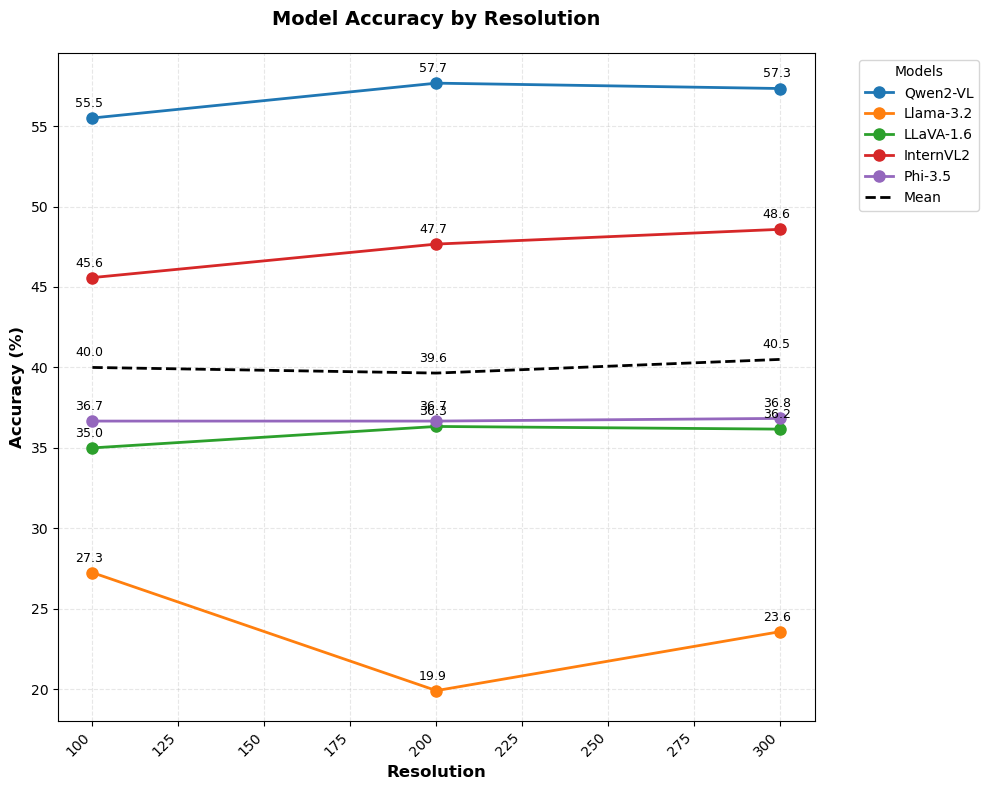


Accuracy by Resolution:
 Resolution  Qwen2-VL  Llama-3.2  LLaVA-1.6  InternVL2  Phi-3.5  Mean
        100     55.50      27.25      35.00      45.58    36.67 40.00
        200     57.67      19.92      36.33      47.67    36.67 39.65
        300     57.33      23.58      36.17      48.58    36.83 40.50


In [129]:
models_map = {
    "Qwen/Qwen2-VL-7B-Instruct": "Qwen2-VL",
    "meta-llama/Llama-3.2-11B-Vision-Instruct": "Llama-3.2",
    "llava-hf/llava-v1.6-mistral-7b-hf": "LLaVA-1.6",
    "OpenGVLab/InternVL2_5-8B-MPO": "InternVL2",
    "microsoft/Phi-3.5-vision-instruct": "Phi-3.5"
}

# Calculate accuracy by resolution for each model
accuracy_by_resolution_dict = {'Resolution': sorted(data['resolution'].unique())}

# Calculate accuracies for each model and resolution
for model_name in model_names:
    # Group by resolution and calculate mean accuracy
    accuracy_by_resolution = data.groupby('resolution')[f'{model_name}_accuracy'].mean() * 100
    # Add to dictionary using shortened model names
    accuracy_by_resolution_dict[models_map[model_name]] = accuracy_by_resolution.tolist()

# Create DataFrame
accuracy_by_resolution_df = pd.DataFrame(accuracy_by_resolution_dict)

# Calculate mean accuracy for each resolution
mean_accuracies = accuracy_by_resolution_df[[col for col in accuracy_by_resolution_df.columns if col != 'Resolution']].mean(axis=1)
accuracy_by_resolution_df['Mean'] = mean_accuracies

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Get unique resolutions and models
resolutions = accuracy_by_resolution_df['Resolution']
models = [col for col in accuracy_by_resolution_df.columns if col not in ['Resolution', 'Mean']]

# Create line plot
for model in models:
    ax.plot(resolutions, accuracy_by_resolution_df[model], marker='o', label=model, linewidth=2, markersize=8)

# Add mean accuracy line
ax.plot(resolutions, accuracy_by_resolution_df['Mean'], 'k--', label='Mean', linewidth=2)

# Customize the plot
ax.set_xlabel('Resolution', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy by Resolution', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(title='Models', title_fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels with adjusted x position
# Get the left boundary of the plot
x_left, _ = ax.get_xlim()
# Calculate an offset for the labels to prevent overlap
offset = (x_left - resolutions.min()) * 0.1 
for model in models + ['Mean']:
    for i, value in enumerate(accuracy_by_resolution_df[model]):
        ax.text(resolutions.iloc[i] + offset, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9)

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print accuracy table
print("\nAccuracy by Resolution:")
print(accuracy_by_resolution_df.round(2).to_string(index=False))

Accuracy by linewidth for Qwen/Qwen2-VL-7B-Instruct:
linewidth
2    58.111111
4    55.555556
Name: Qwen/Qwen2-VL-7B-Instruct_accuracy, dtype: float64
Accuracy by linewidth for meta-llama/Llama-3.2-11B-Vision-Instruct:
linewidth
2    18.388889
4    28.777778
Name: meta-llama/Llama-3.2-11B-Vision-Instruct_accuracy, dtype: float64
Accuracy by linewidth for llava-hf/llava-v1.6-mistral-7b-hf:
linewidth
2    36.444444
4    35.222222
Name: llava-hf/llava-v1.6-mistral-7b-hf_accuracy, dtype: float64
Accuracy by linewidth for OpenGVLab/InternVL2_5-8B-MPO:
linewidth
2    43.722222
4    50.833333
Name: OpenGVLab/InternVL2_5-8B-MPO_accuracy, dtype: float64
Accuracy by linewidth for microsoft/Phi-3.5-vision-instruct:
linewidth
2    38.222222
4    35.222222
Name: microsoft/Phi-3.5-vision-instruct_accuracy, dtype: float64


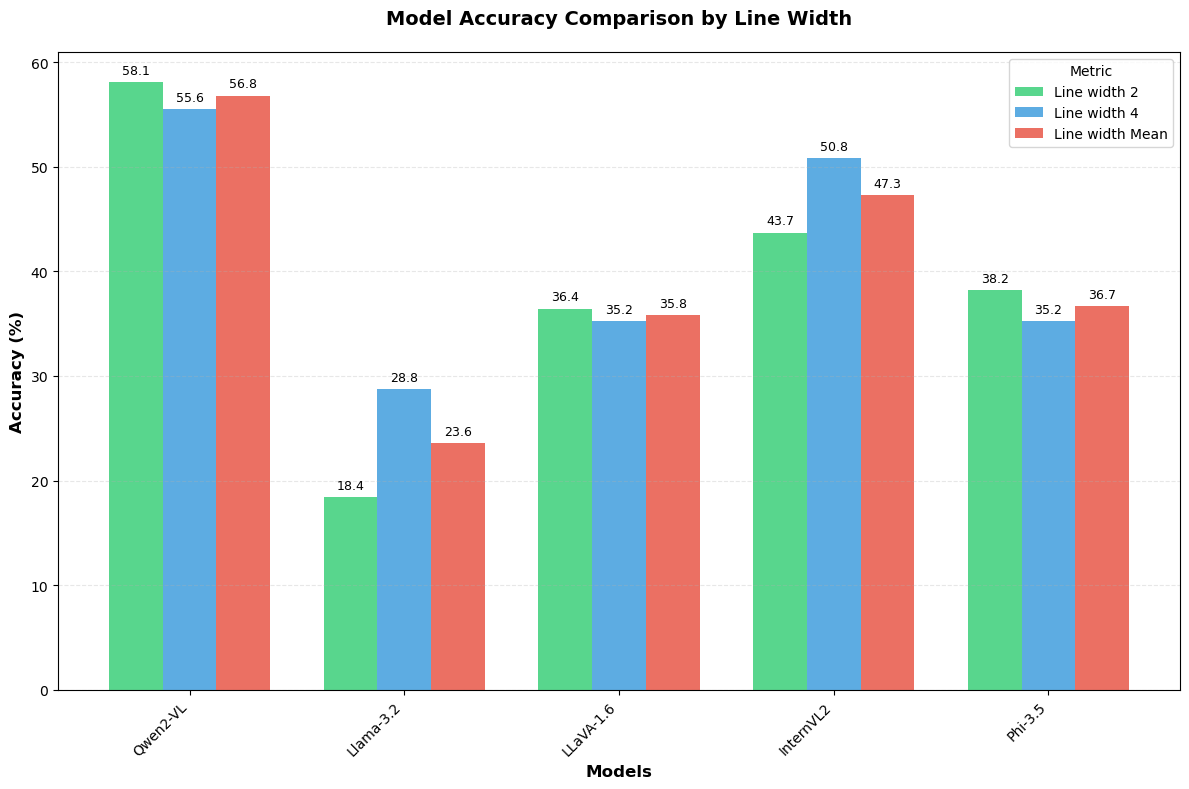

In [130]:
# Calculate accuracy by line width
# Model names (shortened for better display)

accuracy_by_linewidth_dict = {'Line width': [2, 4, 'Mean']}
for model_name in model_names:
    accuracy_by_linewidth = data.groupby('linewidth')[f'{model_name}_accuracy'].mean() * 100
    accuracy_by_linewidth_dict[models_map[model_name]] = accuracy_by_linewidth.tolist() + [accuracy_by_linewidth.mean() * 100]
    print(f"Accuracy by linewidth for {model_name}:\n{accuracy_by_linewidth}")

accuracy_by_linewidth_df = pd.DataFrame(accuracy_by_linewidth_dict)

# Set figure size
plt.figure(figsize=(12, 8))


# Create the main bar plot
width = 0.25
x = np.arange(len(models))

# Plot bars for each line width and mean
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red
bars = []

# Create grouped bars for each line width type
for i, (idx, row) in enumerate(accuracy_by_linewidth_df.iterrows()):
    values = [row[model] for model in models]
    # Convert 'Mean' values to be in the same scale as other values
    if row['Line width'] == 'Mean':
        values = [val if val < 100 else val/100 for val in values]
    
    bars.append(plt.bar(x + (i-1)*width, 
                       values,
                       width, 
                       label=f'Line width {row["Line width"]}',
                       color=colors[i],
                       alpha=0.8))

# Customize the plot
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Accuracy Comparison by Line Width', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend(title='Metric', title_fontsize=10)

# Add value labels on all bars
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

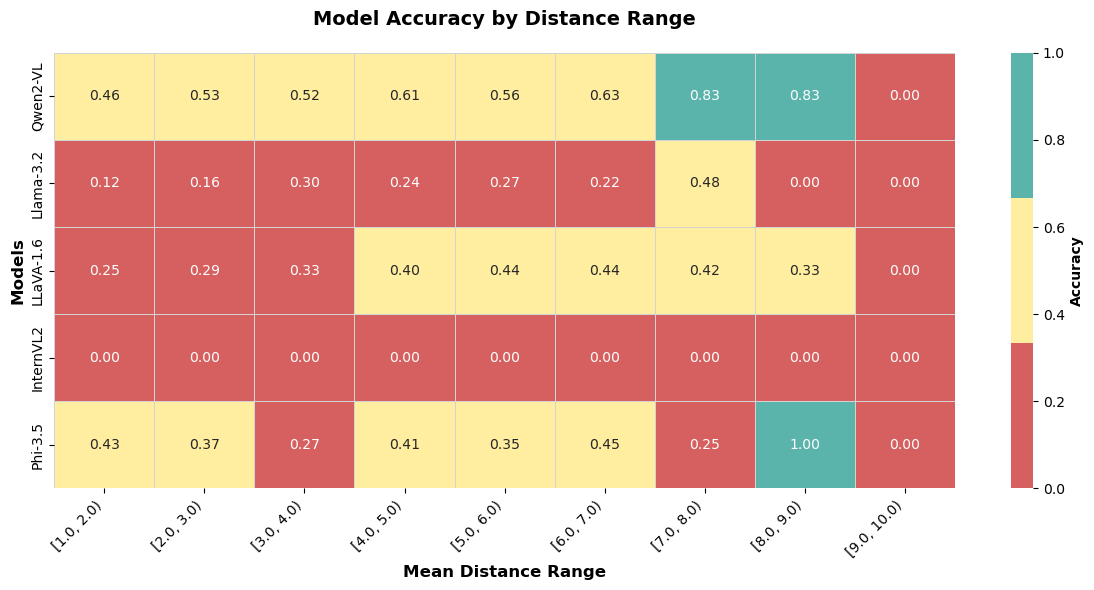

In [132]:
# Create accuracy by distance range heatmap
data = pd.read_csv("data.csv")

bins = [(1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0), 
        (5.0, 6.0), (6.0, 7.0), (7.0, 8.0), (8.0, 9.0), (9.0, 10.0)]

results = []

# Calculate accuracy for each model and distance bin
for model_name in model_names:
    accuracies = []
    for bin_start, bin_end in bins:
        # Filter data for current distance bin
        mask = data['distances'].apply(lambda x: bin_start <= np.mean(eval(x)) < bin_end)
        bin_data = data[mask]
        
        # Calculate accuracy
        if len(bin_data) > 0:
            accuracy = (bin_data[model_name] == bin_data['gt']).mean()
        else:
            accuracy = 0
        accuracies.append(accuracy)
    
    results.append(accuracies)

# Create DataFrame for heatmap
results_df = pd.DataFrame(
    results,
    index=[models_map[model] for model in model_names],  # Use shortened model names
    columns=[f'[{b[0]}, {b[1]})' for b in bins]
)

# Plotting
plt.figure(figsize=(12, 6))

# Create heatmap with customizations to match the line plot style
heatmap = sns.heatmap(
    results_df,
    annot=True,
    fmt='.2f',
    cmap=sns.color_palette(["#d65f5f", "#ffeda0", "#5ab4ac"]),  # Custom color palette based on line plot
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Accuracy'},
    linewidths=0.5,  # Add cell borders
    linecolor='lightgray'  # Set cell border color
)

# Customize the plot to match the line plot style
heatmap.set_xlabel('Mean Distance Range', fontsize=12, fontweight='bold')
heatmap.set_ylabel('Models', fontsize=12, fontweight='bold')
heatmap.set_title('Model Accuracy by Distance Range', fontsize=14, fontweight='bold', pad=20)

# Set font properties for annotations
for text in heatmap.texts:
    text.set_fontproperties({'family': 'DejaVu Sans', 'weight': 'normal', 'size': 10})

# Set font properties for tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right', fontproperties={'family': 'DejaVu Sans', 'weight': 'normal', 'size': 10})
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontproperties={'family': 'DejaVu Sans', 'weight': 'normal', 'size': 10})

# Customize colorbar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Accuracy', fontproperties={'family': 'DejaVu Sans', 'weight': 'bold', 'size': 10})

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()